In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import datetime as dt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [269]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

### Import dataframe for 911 calls for service in Baltimore

In [8]:
df = pd.read_csv('C:/Users/tsen6/Desktop/Python/Analysis911/911_Police_Calls_for_Service.csv')

C:\Users\tsen6\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823490 entries, 0 to 7823489
Data columns (total 20 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   RecordID                     int64  
 1   CallNumber                   object 
 2   CallDateTime                 object 
 3   Priority                     object 
 4   District                     object 
 5   Description                  object 
 6   IncidentLocation             object 
 7   ZipCode                      float64
 8   Neighborhood                 object 
 9   PoliceDistrict               object 
 10  PolicePost                   float64
 11  CouncilDistrict              float64
 12  SheriffDistricts             object 
 13  Community_Statistical_Areas  object 
 14  Census_Tracts                object 
 15  VRIZones                     object 
 16  Location                     object 
 17  2010 Census Neighborhoods    float64
 18  2010 Census Wards Precincts  float64
 19  

Cleaning and setting variable types in dataframe columns

In [9]:
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df.dropna(subset=['Census_Tracts'])
df = df.dropna(subset=['PoliceDistrict'])
df = df.dropna(subset=['Priority'])
df['Count'] = 1

def cen_tract(tract_string):
    tract = float(str(tract_string).split()[2])
    return tract

df.Census_Tracts = df.apply(lambda x: cen_tract(x['Census_Tracts']),axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7745304 entries, 0 to 7823489
Data columns (total 21 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   RecordID                     int64         
 1   CallNumber                   object        
 2   CallDateTime                 datetime64[ns]
 3   Priority                     object        
 4   District                     object        
 5   Description                  object        
 6   IncidentLocation             object        
 7   ZipCode                      float64       
 8   Neighborhood                 object        
 9   PoliceDistrict               object        
 10  PolicePost                   float64       
 11  CouncilDistrict              float64       
 12  SheriffDistricts             object        
 13  Community_Statistical_Areas  object        
 14  Census_Tracts                float64       
 15  VRIZones                     object        
 16  

Removing low priorty, non-emergency and out-of-service calls

In [29]:
dfHighEmer = df[['RecordID','CallDateTime','Priority','Description','PoliceDistrict',
               'Census_Tracts','Count']]
dfHighEmer = dfHighEmer[(dfHighEmer['Priority']!='Low') 
                    & (dfHighEmer['Priority']!='Non-Emergency')
                    & (dfHighEmer['Priority']!='Out of Service')]

### Agglomerating records to census tract level, also converting counts to weekly (rather than daily)

In [219]:
ND_file = 'Tract_ND_fin.csv' #'Tract_ND.csv'
PD_tract = pd.read_csv('Tract_PD2.csv') #('Tract_PD.csv')
ND_tract = pd.read_csv(ND_file) #
# ND_tract.info()

dfWeekly = pd.DataFrame()
for cd in df.Census_Tracts.unique():    
    PD = PD_tract[PD_tract['census_tracts']==cd].Police_district
    policeD = (PD.tolist()[0])
    ND = ND_tract[ND_tract['census_tracts']==cd].New_district
    newD = (ND.tolist()[0])
    
    Temp = dfHighEmer[(dfHighEmer['Census_Tracts']==cd)]
    dfSumNew = Temp.groupby(pd.Grouper(key='CallDateTime', freq='W'))['Count'].sum()
    dfTemp = pd.DataFrame(dfSumNew) 
    dfTemp['Date'] = dfSumNew.index
    dfTemp['Census_Tracts'] = cd
    dfTemp['PoliceDistrict'] = policeD    
    dfTemp['New_district'] = newD
    
    dfWeekly = dfWeekly.append(dfTemp)

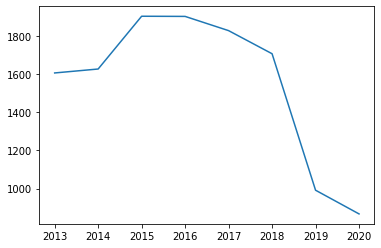

In [220]:
dfSum = dfHighEmer['Count'].groupby(dfHighEmer['CallDateTime'].dt.date).sum()
dfSum = pd.DataFrame(data=dfSum)
dfSum = dfSum.reset_index()
dfSum = dfSum.rename(columns={"CallDateTime": "ds","Count":"y"})
dfSum['ds'] = pd.to_datetime(dfSum['ds'])
means = dfSum['y'].groupby(dfSum['ds'].dt.year).mean()
plt.plot(means)

mean1, mean2, mean3 = [], [], []
for i in range(2015,2019):
    mean1.append(means[i])
for i in [2013,2014]:
    mean2.append(means[i])
for i in [2019,2020]:
    mean3.append(means[i])
    
mean1 = np.mean(mean1)
mean2 = np.mean(mean2)
mean3 = np.mean(mean3)

In [266]:
dfWeekNorm = pd.DataFrame()
k = 0
for i in [2013,2014]:
    if len(dfWeekNorm)!=0:        
        dTemp = dfWeekly[dfWeekly['Date'].dt.year==i][:-2] #['Count']* mean2/mean2
        dTemp['Count'] = dTemp['Count']* mean2/mean2
        dfWeekNorm = pd.concat([dfWeekNorm,dTemp])
    else:
        dfWeekNorm = dfWeekly[dfWeekly['Date'].dt.year==i][:-2]
        dfWeekNorm['Count']=dfWeekNorm['Count'] * mean2/mean2
    k+=1
    
k = 0
for i in range(2015,2019):
    if len(dfWeekNorm)!=0:        
        dTemp = dfWeekly[dfWeekly['Date'].dt.year==i][:-2]
        dTemp['Count'] = dTemp['Count']* mean2/mean1
        dfWeekNorm = pd.concat([dfWeekNorm,dTemp])
    else:
        dfWeekNorm = dfWeekly[dfWeekly['Date'].dt.year==i][:-2]
        dfWeekNorm['Count']=dfWeekNorm['Count'] * mean2/mean1
    k+=1

k = 0
for i in range(2019,2021):
    if len(dfWeekNorm)!=0:        
        dTemp = dfWeekly[dfWeekly['Date'].dt.year==i][:-2]
        dTemp['Count']=dTemp['Count'] * mean2/mean3
        dfWeekNorm = pd.concat([dfWeekNorm,dTemp])
    else:
        dfWeekNorm = dfWeekly[dfWeekly['Date'].dt.year==i][:-2]
        dfWeekNorm['Count']=dfWeekNorm['Count'] * mean2/mean3
    k+=1

dfWeekNorm = dfWeekNorm.sort_values(by=['Date'])

### Creating features to be used in Random Forest Regression for predicting future values.
Features include label-encoded census tracts (0-199), one-hot encoded ditrict (9), week, month, year, sales last week, difference in sales between last week and this week. (Annual seasonal variation was obserevd during EDA which suggests including week and month information)

In [267]:
dfWeekNorm = dfWeekNorm.reset_index(drop=True)
dfWeekNorm['Year']=dfWeekNorm['Date'].dt.year
dfWeekNorm['Month']=dfWeekNorm['Date'].dt.month
dfWeekNorm['Week']=dfWeekNorm['Date'].dt.week

# creating instance of labelencoder
labelencoder = LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')

# Assigning numerical values and storing in another column
dfWeekNorm['Census_Tracts_Cat'] = labelencoder.fit_transform(dfWeekNorm['Census_Tracts'])
dfWeekNorm['PoliceDistrict_Cat'] = labelencoder.fit_transform(dfWeekNorm['PoliceDistrict'])

# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(dfWeekNorm[['PoliceDistrict_Cat']]).toarray())
# merge with main df bridge_df on key values
dfWeekNorm = dfWeekNorm.join(enc_df)
dfWeekNorm = dfWeekNorm.drop(columns = ['Census_Tracts','PoliceDistrict',
                                    'New_district', 'PoliceDistrict_Cat'])

dfWeekNorm['Last_Week_Sales'] = dfWeekNorm.groupby(['Census_Tracts_Cat'
                                                   ])['Count'].shift()
dfWeekNorm['Last_Week_Diff'] = dfWeekNorm.groupby(['Census_Tracts_Cat'
                                                  ])['Last_Week_Sales'].diff()
dfWeekNorm = dfWeekNorm.dropna()
# dfWeekNorm = dfWeekNorm.drop(columns = ['Last_Week_Sales'])

dfWeekNorm[dfWeekNorm['Census_Tracts_Cat']==87]

,Count,Date,Year,Month,Week,Census_Tracts_Cat,0,1,2,3,4,5,6,7,8,Last_Week_Sales,Last_Week_Diff
216,54.000000,2013-07-14,2013,7,28,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,84.000000,83.000000
405,41.000000,2013-07-21,2013,7,29,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,54.000000,-30.000000
700,43.000000,2013-07-28,2013,7,30,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,41.000000,-13.000000
826,50.000000,2013-08-04,2013,8,31,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,43.000000,2.000000
1028,68.000000,2013-08-11,2013,8,32,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71530,38.262905,2020-05-10,2020,5,19,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.133581,13.913784
71653,27.827568,2020-05-17,2020,5,20,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,38.262905,-20.870676
71927,59.133581,2020-05-24,2020,5,21,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.827568,-10.435338
72013,46.959020,2020-05-31,2020,5,22,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.133581,31.306013


### Running Random Forest Model
Setting up the error metric

In [268]:
def MAPE_func(pred, actual):    
    return ((abs(pred-actual)/(actual+1)*100)).mean()

Test-train split parameters

In [270]:
split = 0.8 #weeks
datesCV = dfWeekly.groupby(pd.Grouper(key='Date', freq='W'))['Count'].sum()
datesCV = datesCV.index
nsteps = 130
nstart = int(len(datesCV)*split)
from datetime import timedelta

Walk forward cross-validation on 20% of data. We consider a 3-month walk forward each iteration

In [313]:
j = 0
mean_error = []
for id in range(2*int(nsteps/7),len(datesCV),int(nsteps/7)):
    
    train = dfWeekNorm[dfWeekNorm.Date < datesCV[id]].drop(columns = ['Date'])
    xtr = train.drop(['Count'], axis=1)
    ytr = train['Count'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p,yts = [],[]
    week_before = dfWeekNorm[(dfWeekNorm.Date > datesCV[id]-timedelta(days=14)
                              ) &  (dfWeekNorm.Date <=
                                    datesCV[id]-timedelta(days=7))].drop(columns = ['Date'])
    new = dfWeekNorm[(dfWeekNorm.Date > datesCV[id]-timedelta(days=7)
                              ) &  (dfWeekNorm.Date <= datesCV[id])].drop(columns = ['Date'])
    lastWeek = new
    for step in range(0,nsteps,7):
        PrevCount = week_before.set_index('Census_Tracts_Cat')['Count']
        
        val = dfWeekNorm[(dfWeekNorm.Date > datesCV[id]) &
                         (dfWeekNorm.Date <= datesCV[id]+timedelta(
                             days=7))].drop(columns = ['Date'])
        act = val['Count'].values
        
        xts = val.drop(columns = ['Count','Last_Week_Sales','Last_Week_Diff'])
        
        Last_Week_Diff = pd.DataFrame(lastWeek.set_index(
            'Census_Tracts_Cat')['Count']-week_before.set_index('Census_Tracts_Cat')['Count'])
        
        Last_Week_Sales = pd.DataFrame(lastWeek.groupby(['Census_Tracts_Cat'
                                                   ])['Count'].sum()).reset_index()
        
        xts = xts.join(Last_Week_Sales.set_index('Census_Tracts_Cat'), on='Census_Tracts_Cat')
        xts = xts.rename(columns = {"Count": "Last_Week_Sales"})
        xts = xts.join(Last_Week_Diff, on='Census_Tracts_Cat')
        xts = xts.rename(columns = {"Count": "Last_Week_Diff"})
        xts = xts.fillna(0)
        
        new = mdl.predict(xts)
#         print(new)
        
        week_before = lastWeek
        lastWeek = pd.DataFrame({'Census_Tracts_Cat' : xts['Census_Tracts_Cat'],
                                'Count': new})
        p = np.hstack((p,new))
        yts = np.hstack((yts, act))
        
    error = MAPE_func(yts, p)
    print('Step %d - Error %.5f' % (j, error))
    mean_error.append(error)
    j+=1
print('Mean Error = %.5f' % np.mean(mean_error))
        

Step 0 - Error 26.92229
Step 1 - Error 22.43247
Step 2 - Error 24.10542
Step 3 - Error 27.37867
Step 4 - Error 20.03595
Step 5 - Error 22.26351
Step 6 - Error 23.17588
Step 7 - Error 21.41481
Step 8 - Error 22.66201
Step 9 - Error 22.16500
Step 10 - Error 21.97540
Step 11 - Error 22.59825
Step 12 - Error 22.50861
Step 13 - Error 20.94420
Step 14 - Error 28.41274
Step 15 - Error 26.45578
Step 16 - Error 24.95651
Step 17 - Error 30.65233
Step 18 - Error 30.43218
Mean Error = 24.28905


Looking at feature importances

As expected there is a very strong dependence on "Counts Last Week" which is not included below. This plot shows relative importance of other features used in the analysis


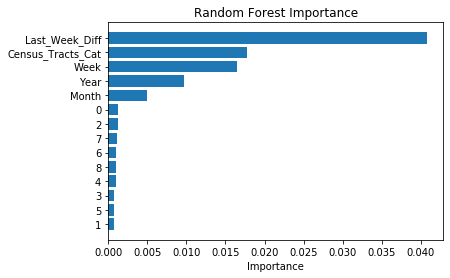

In [329]:
importances = mdl.feature_importances_
arr = xtr.columns
dfFeat = pd.DataFrame({'features' : arr, 'importances' : arr1})
dfFeat = dfFeat.sort_values('importances').reset_index(drop=True)[0:-1]

fig, ax = plt.subplots()

ax.barh(dfFeat['features'].astype(str), dfFeat['importances'])
ax.set_xlabel('Importance')
ax.set_title('Random Forest Importance')

print('As expected there is a very strong dependence on "Counts Last Week"',
      'which is not included below.',
      'This plot shows relative importance of other features used in the analysis')
plt.show()


## Hyperparameter tuning for random forest regression

Setting up the grid of hyperparameters to be searched

In [325]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Random grid search over selected hyperparameters, CV fold set to 2 (minimim allowed) to minimize overfitting from prediction of past values using model trained on future values

In [326]:
train = dfWeekNorm[dfWeekNorm.Date 
                            < datesCV[2*int(nsteps/7)]
                           ].drop(columns = ['Date'])
train_features = train.drop(['Count'], axis=1)
train_vals = train['Count'].values

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 50, cv = 2, 
                               verbose=2, random_state=42, 
                               n_jobs = -1)# Fit the random search model
rf_random.fit(train_features, train_vals)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [233]:
rf_random.best_params_

{'n_estimators': 911,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

### Final run of Random Forest regression using optimal hyperparameters. 
Not much change in overall fit over baseline Random Forest model

In [330]:
best_random = rf_random.best_estimator_
j = 0
mean_error = []
for id in range(2*int(nsteps/7),len(datesCV),int(nsteps/7)):
    
    train = dfWeekNorm[dfWeekNorm.Date < datesCV[id]].drop(columns = ['Date'])

    xtr = train.drop(['Count'], axis=1)
    ytr = train['Count'].values

    mdl = best_random
    mdl.fit(xtr, ytr)
    
    p,yts = [],[]
    week_before = dfWeekNorm[(dfWeekNorm.Date > datesCV[id]-timedelta(days=14)
                              ) &  (dfWeekNorm.Date <=
                                    datesCV[id]-timedelta(days=7))].drop(columns = ['Date'])
    new = dfWeekNorm[(dfWeekNorm.Date > datesCV[id]-timedelta(days=7)
                              ) &  (dfWeekNorm.Date <= datesCV[id])].drop(columns = ['Date'])
    lastWeek = new
    for step in range(0,nsteps,7):
        PrevCount = week_before.set_index('Census_Tracts_Cat')['Count']
        
        val = dfWeekNorm[(dfWeekNorm.Date > datesCV[id]) &
                         (dfWeekNorm.Date <= datesCV[id]+timedelta(
                             days=7))].drop(columns = ['Date'])
        act = val['Count'].values
        
        xts = val.drop(columns = ['Count','Last_Week_Sales','Last_Week_Diff'])
        
        Last_Week_Diff = pd.DataFrame(lastWeek.set_index(
            'Census_Tracts_Cat')['Count']-week_before.set_index('Census_Tracts_Cat')['Count'])
        
        Last_Week_Sales = pd.DataFrame(lastWeek.groupby(['Census_Tracts_Cat'
                                                   ])['Count'].sum()).reset_index()
        
        xts = xts.join(Last_Week_Sales.set_index('Census_Tracts_Cat'), on='Census_Tracts_Cat')
        xts = xts.rename(columns = {"Count": "Last_Week_Sales"})
        xts = xts.join(Last_Week_Diff, on='Census_Tracts_Cat')
        xts = xts.rename(columns = {"Count": "Last_Week_Diff"})
        xts = xts.fillna(0)
        
        new = mdl.predict(xts)
        
        week_before = lastWeek
        lastWeek = pd.DataFrame({'Census_Tracts_Cat' : xts['Census_Tracts_Cat'],
                                'Count': new})
        p = np.hstack((p,new))
        yts = np.hstack((yts, act))
    
    error = MAPE_func(yts, p)
    print('Step %d - Error %.5f' % (j, error))
    mean_error.append(error)
    j+=1
print('Mean Error = %.5f' % np.mean(mean_error))

Step 0 - Error 26.55976
Step 1 - Error 21.71278
Step 2 - Error 23.03818
Step 3 - Error 24.21790
Step 4 - Error 19.47125
Step 5 - Error 20.35330
Step 6 - Error 20.26015
Step 7 - Error 20.15425
Step 8 - Error 22.43046
Step 9 - Error 21.15253
Step 10 - Error 20.94591
Step 11 - Error 22.49636
Step 12 - Error 22.01007
Step 13 - Error 20.88724
Step 14 - Error 26.21413
Step 15 - Error 25.00612
Step 16 - Error 22.96657
Step 17 - Error 28.53494
Step 18 - Error 30.22071
Mean Error = 23.08593
